## ЧАСТЬ 1

+ Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.
+ Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение BlackjackEnv из OpenAI Gym.
+ Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.


#### 1.Детерминированная стратегия (stand if [19,20,21] else hit) + MC First Visit

##### Настраиваем среду

In [3]:
from typing import Optional
import gym
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from tqdm import tqdm

import bj_base_gym
from gym import spaces
from bj_base_gym import draw_card, is_natural, score, sum_hand, cmp, is_bust


env = bj_base_gym.BlackjackEnv(render_mode='rgb_array')

TOTAL_EPISODES = 1000000
NA = env.action_space.n


In [4]:
num_episodes = 3

for i in range(num_episodes):
    print('Episode : ', i+1)
    state = env.reset()
    step = 0
    print(f"START Players hand {env.player}, \t Dealers Hand {env.dealer}")
    while True:
        step +=1
        action = env.action_space.sample()
        state, reward, done, _, _ = env.step(action)
        print(f'Step = {step}\t State = {state}\t Action Taken = {action}', end = ' ')
        if action == 1:
            print(f'(Card Drawn -  {env.player[-1]})')
        if done:
            print('\nGame Ended')
            print(f" END Players hand {env.player}, \t Dealers Hand {env.dealer}")
            if reward > 0: print('Agent Won!\n')
            else: print('Agent Lost!\n')
            break


Episode :  1
START Players hand [5, 10], 	 Dealers Hand [8, 7]
Step = 1	 State = (24, 8, False)	 Action Taken = 1 (Card Drawn -  9)

Game Ended
 END Players hand [5, 10, 9], 	 Dealers Hand [8, 7]
Agent Lost!

Episode :  2
START Players hand [10, 10], 	 Dealers Hand [6, 2]
Step = 1	 State = (20, 6, False)	 Action Taken = 0 
Game Ended
 END Players hand [10, 10], 	 Dealers Hand [6, 2, 10]
Agent Won!

Episode :  3
START Players hand [2, 6], 	 Dealers Hand [5, 10]
Step = 1	 State = (8, 5, False)	 Action Taken = 0 
Game Ended
 END Players hand [2, 6], 	 Dealers Hand [5, 10, 10]
Agent Won!



Все отлично!

#### Реализуем наивную стратегию + MC First Visit

In [5]:
HIT, STAND = 1,0

def determinated_policy(observation):
    hand_sum, _, _ = observation
    return STAND if hand_sum >= 19 else HIT

def run_episode(env, policy):
    states, actions, rewards = [], [], []
    obs, _ = env.reset()
    terminated = False
    while not terminated:
        states.append(obs)
        action = policy(obs)
        actions.append(action)
        obs, reward, terminated , _ , _ = env.step(action)
        rewards.append(reward)
    return states, actions, rewards

def first_visit_mc_prediction(env, policy, n_episodes, gamma=1.0):
    value_table = defaultdict(float)
    N = defaultdict(int)
    all_rewards = np.zeros(n_episodes)
    
    for i in tqdm(range(n_episodes)):
        states, _, rewards = run_episode(env, policy)
        returns = 0
        for j, t in enumerate(range(len(states) - 1, -1, -1)):
            R = rewards[t]
            S = states[t]
            # discount reward
            returns += (gamma**j) * R
            if S not in states[:t]:
                N[S] += 1
                value_table[S] += (returns - value_table[S]) / N[S]
        
        all_rewards[i] = rewards[-1]    
    return value_table, all_rewards

сразу будем подбирать параметр гамма, и нарисуем получившиеся значения

100%|██████████| 1000000/1000000 [01:50<00:00, 9018.04it/s]


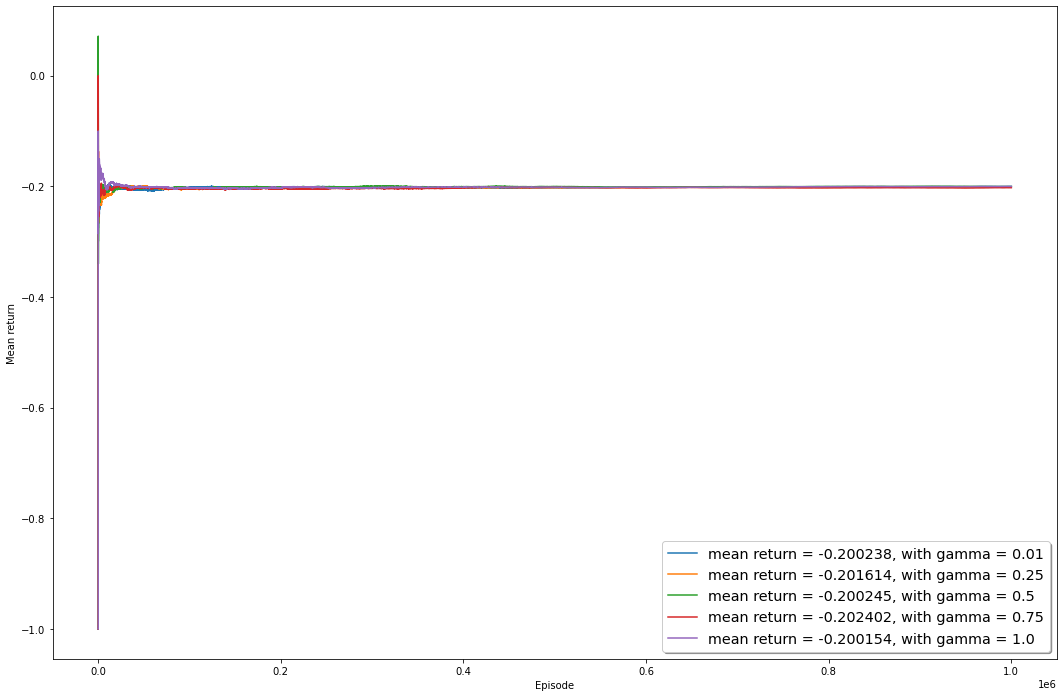

In [7]:

plt.figure(figsize=(18,12))
for gamma in [0.01,0.25,0.5,0.75,1.0]:
    _, rewards = first_visit_mc_prediction(env, determinated_policy, n_episodes=TOTAL_EPISODES, gamma = gamma)
    mean_rewards = [cs / (i+1) for i, cs in enumerate(np.cumsum(rewards))]
    plt.plot(mean_rewards, label=f'mean return = {np.mean(rewards)}, with gamma = {gamma}')
plt.legend(loc='lower right', shadow=True, fontsize='x-large')
plt.xlabel('Episode')
plt.ylabel('Mean return')
plt.show()

Как видно - достаточно плохие результаты при данной стратегии

##### 2. Реализуем MC Off-policy control

In [10]:
import sys 

def get_probs(Q_s, epsilon, nA):
    policy_s = np.ones(nA) * epsilon / nA
    best_a = np.argmax(Q_s)
    policy_s[best_a] = 1 - epsilon + (epsilon / nA)
    return policy_s

def update_Q(env, episode, Q, alpha, gamma):
    for s, a, r in episode:
        first_occurence_idx = next(i for i,x in enumerate(episode) if x[0] == s)
        G = sum([x[2]*(gamma**i) for i,x in enumerate(episode[first_occurence_idx:])])
        Q[s][a] = Q[s][a] + alpha*(G - Q[s][a])
    return Q


def run_episode(env, Q, epsilon, nA):
    episode = []
    state = env.reset()[0]
    done = False
    while not done:
        probs = get_probs(Q[state], epsilon, nA)
        action = np.random.choice(np.arange(nA), p=probs) \
                                    if state in Q else env.action_space.sample()
        next_state, reward, done, _ , _ = env.step(action)
        episode.append((state, action, reward))
        state = next_state
    return episode


def mc_control(env, n_episodes, epsilon = .1, gamma = 1.0, alpha = .001 , tqdm_disabled = False):
    nA = env.action_space.n
    Q = defaultdict(lambda: np.zeros(nA))
    rewards = np.zeros(n_episodes)
    for i in tqdm(range(n_episodes), disable = tqdm_disabled):
        episode = run_episode(env, Q, epsilon, nA)
        rewards[i] = episode[-1][-1]
        Q = update_Q(env, episode, Q, alpha, gamma)
    policy = dict((k,np.argmax(v)) for k, v in Q.items())
    return policy, Q, rewards

#реализуем подбор гиперпараметров для модели (на 10000 итерациях)
def tune_mc_control_hyperparams(env ,epsilons, gammas, alphas):
    best_epsilon = None
    best_gamma = None
    best_alpha = None 
    best_reward = -1
    for epsilon in tqdm(epsilons):
        for gamma in gammas:
            for alpha in alphas:
                _, _, rewards_mc = mc_control(env, TOTAL_EPISODES // 100, epsilon=epsilon, gamma=gamma, alpha=alpha, tqdm_disabled=True)
                mean_reward = np.mean(rewards_mc)
                if mean_reward > best_reward:
                    best_reward = mean_reward
                    best_epsilon = epsilon
                    best_alpha = alpha
                    best_gamma = gamma
    print(f'Best epsilon = {best_epsilon}, best gamma = {best_gamma}, best_alpha = {best_alpha}')
    return best_epsilon, best_gamma, best_alpha

100%|██████████| 4/4 [05:34<00:00, 83.75s/it]


Best epsilon = 0.05, best gamma = 0.6, best_alpha = 0.126


100%|██████████| 1000000/1000000 [02:34<00:00, 6485.00it/s]


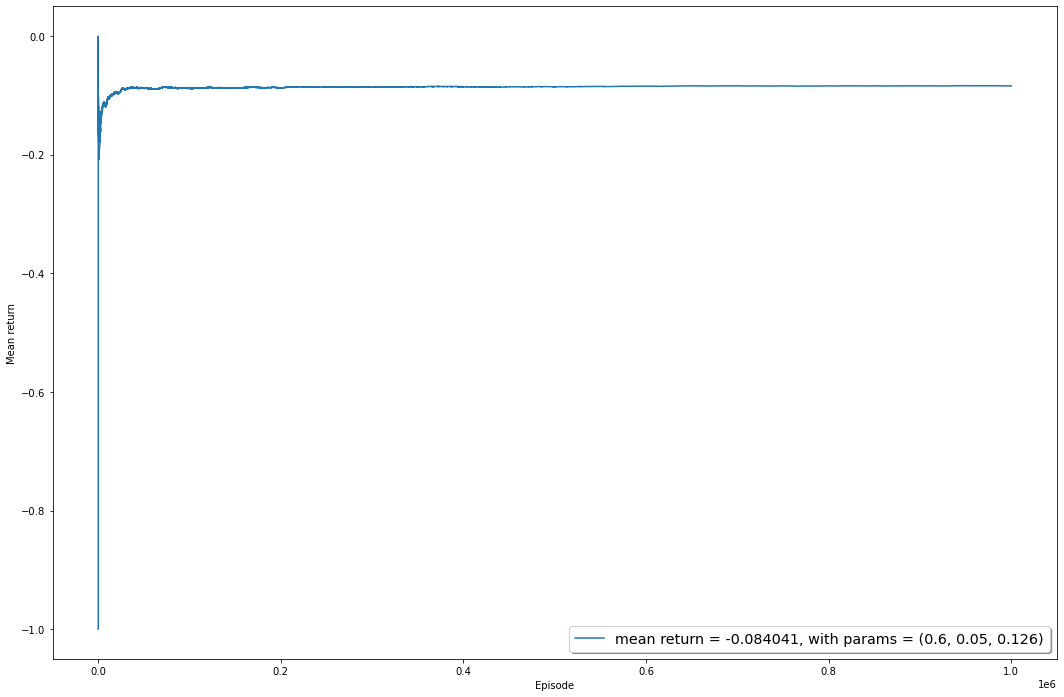

In [11]:
plt.figure(figsize=(18,12))
epsilons = np.arange(.05, .21, .05)
gammas = np.arange(.1, 1.1, .1)
alphas = np.arange(.001, .151, .025)

best_epsilon, best_gamma, best_alpha = tune_mc_control_hyperparams(env, epsilons, gammas, alphas)
_, _, rewards_mc = mc_control(env, TOTAL_EPISODES, epsilon=best_epsilon, gamma=best_gamma, alpha=best_alpha)
mean_rewards = [cs / (i+1) for i, cs in enumerate(np.cumsum(rewards_mc))]
plt.plot(mean_rewards, label=f'mean return = {np.mean(rewards_mc)}, with params = {(best_gamma,best_epsilon,best_alpha)}')
plt.legend(loc='lower right', shadow=True, fontsize='x-large')
plt.xlabel('Episode')
plt.ylabel('Mean return')
plt.show()

## ЧАСТЬ 2, удвоенная

+ Реализуйте новый вариант блекджека на основе окружения BlackjackEnv из OpenAI Gym, в котором разрешено удвоение ставки.
+ Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.


In [12]:
#немного перепишем исходный класс

class BJ_env_with_double(bj_base_gym.BlackjackEnv):
    def __init__(self, render_mode: Optional[str] = None, natural=False, sab=False):
        super().__init__(render_mode, natural, sab)
        self.action_space = spaces.Discrete(3)

    def step(self, action):
        assert self.action_space.contains(action)
        if action == 1:  # hit: add a card to players hand and return
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                terminated = True
                reward = -1.0
            else:
                terminated = False
                reward = 0.0
        else:  # stick: play out the dealers hand, and score
            if action == 2: # Удвоение
                self.player.append(draw_card(self.np_random))
            terminated = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if action == 2: #Награда при удвоении
                reward *= 2
            if self.sab and is_natural(self.player) and not is_natural(self.dealer):
                # Player automatically wins. Rules consistent with S&B
                reward = 1.0
            elif (
                not self.sab
                and self.natural
                and is_natural(self.player)
                and reward == 1.0
            ):
                # Natural gives extra points, but doesn't autowin. Legacy implementation
                reward = 1.5

        if self.render_mode == "human":
            self.render()
        return self._get_obs(), reward, terminated, False, {}



env_with_double = BJ_env_with_double(render_mode='rgb_array')

Проверим, работает ли

In [13]:
num_episodes = 3

for i in range(num_episodes):
    print('Episode : ', i+1)
    state = env_with_double.reset()
    step = 0
    print(f"START Players hand {env_with_double.player}, \t Dealers Hand {env_with_double.dealer}")
    while True:
        step +=1
        action = env_with_double.action_space.sample()
        state, reward, done, _, _ = env_with_double.step(action)
        print(f'Step = {step}\t State = {state}\t Action Taken = {action}', end = ' ')
        if action == 1:
            print(f'(Card Drawn -  {env_with_double.player[-1]})')
        if done:
            print(f'\nGame Ended')
            print(f"END Players hand {env_with_double.player}, \t Dealers Hand {env_with_double.dealer}")
            if reward > 0: print(f'Agent Won with reward = {reward}!\n')
            else: print('Agent Lost!\n')
            break


Episode :  1
START Players hand [1, 6], 	 Dealers Hand [10, 7]
Step = 1	 State = (17, 10, True)	 Action Taken = 0 
Game Ended
END Players hand [1, 6], 	 Dealers Hand [10, 7]
Agent Lost!

Episode :  2
START Players hand [10, 6], 	 Dealers Hand [2, 10]
Step = 1	 State = (26, 2, False)	 Action Taken = 1 (Card Drawn -  10)

Game Ended
END Players hand [10, 6, 10], 	 Dealers Hand [2, 10]
Agent Lost!

Episode :  3
START Players hand [2, 5], 	 Dealers Hand [1, 7]
Step = 1	 State = (14, 1, False)	 Action Taken = 1 (Card Drawn -  7)
Step = 2	 State = (14, 1, False)	 Action Taken = 0 
Game Ended
END Players hand [2, 5, 7], 	 Dealers Hand [1, 7]
Agent Lost!



100%|██████████| 4/4 [05:33<00:00, 83.36s/it]


Best epsilon = 0.05, best gamma = 0.30000000000000004, best_alpha = 0.126


100%|██████████| 1000000/1000000 [02:35<00:00, 6422.50it/s]


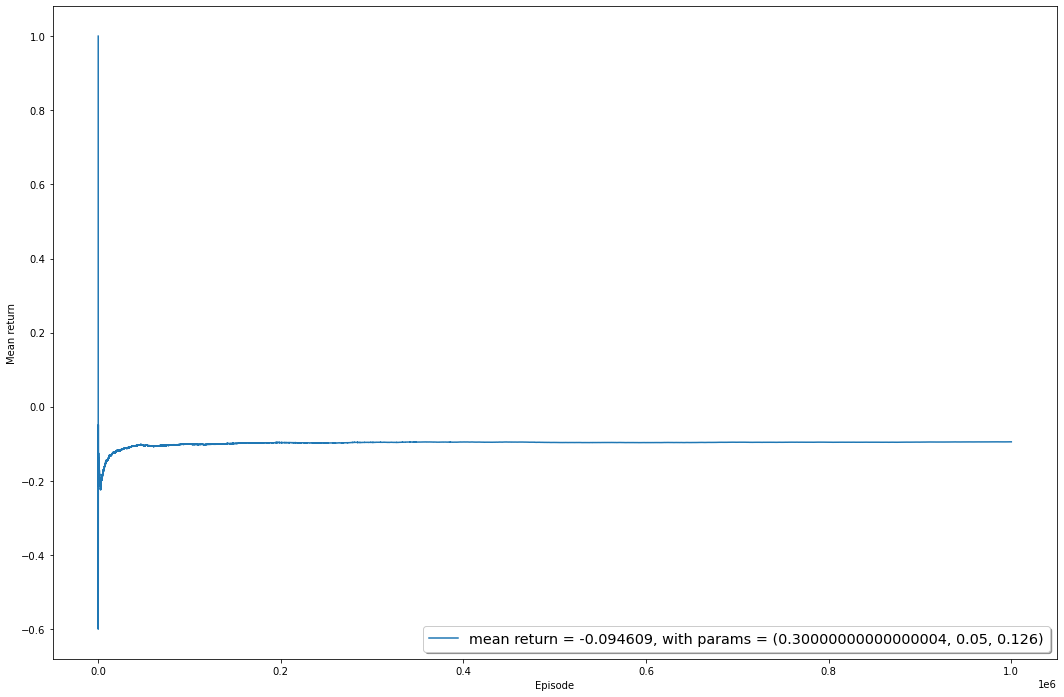

In [14]:
plt.figure(figsize=(18,12))
epsilons = np.arange(.05, .21, .05)
gammas = np.arange(.1, 1.1, .1)
alphas = np.arange(.001, .151, .025)

best_epsilon, best_gamma, best_alpha = tune_mc_control_hyperparams(env_with_double, epsilons, gammas, alphas)
_, _, rewards_mc = mc_control(env_with_double, TOTAL_EPISODES, epsilon=best_epsilon, gamma=best_gamma, alpha=best_alpha)
mean_rewards = [cs / (i+1) for i, cs in enumerate(np.cumsum(rewards_mc))]
plt.plot(mean_rewards, label=f'mean return = {np.mean(rewards_mc)}, with params = {(best_gamma,best_epsilon,best_alpha)}')
plt.legend(loc='lower right', shadow=True, fontsize='x-large')
plt.xlabel('Episode')
plt.ylabel('Mean return')
plt.show()

## Часть третья, в главной роли — Дастин Хоффман

+ Реализуйте вариант окружения BlackjackEnv из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде. Это можно сделать разными способами; возможно, вам поможет статья википедии о блекджеке (а возможно, и нет).
+ Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.


In [15]:
#пришлось многое что переписать, поэтому среда оформлена в отдельный скрипт, где реализованы два подхода к подсчету карт
import bj_counting 
env_with_counting = bj_counting.BlackjackEnv()

In [16]:
num_episodes = 3

for i in range(num_episodes):
    print('Episode : ', i+1)
    state = env_with_counting.reset()
    step = 0
    print(f"START Players hand {env_with_counting.player}, \t Dealers Hand {env_with_counting.dealer}")
    while True:
        step +=1
        action = env_with_counting.action_space.sample()
        state, reward, done, _, _ = env_with_counting.step(action)
        print(f'Step = {step}\t State = {state}\t Action Taken = {action}', end = ' ')
        if action == 1:
            print(f'(Card Drawn -  {env_with_counting.player[-1]})')
        if done:
            print(f'\nGame Ended')
            print(f"END Players hand {env_with_counting.player}, \t Dealers Hand {env_with_counting.dealer}")
            if reward > 0: print(f'Agent Won with reward = {reward}!\n')
            else: print('Agent Lost!\n')
            break


Episode :  1
START Players hand [5, 10], 	 Dealers Hand [9, 10]
Step = 1	 State = (25, 9, False, -2.0)	 Action Taken = 2 
Game Ended
END Players hand [5, 10, 10], 	 Dealers Hand [9, 10]
Agent Lost!

Episode :  2
START Players hand [10, 4], 	 Dealers Hand [10, 2]
Step = 1	 State = (14, 10, False, -1.0)	 Action Taken = 0 
Game Ended
END Players hand [10, 4], 	 Dealers Hand [10, 2, 5]
Agent Lost!

Episode :  3
START Players hand [1, 3], 	 Dealers Hand [3, 8]
Step = 1	 State = (12, 3, False, 0.0)	 Action Taken = 1 (Card Drawn -  8)
Step = 2	 State = (12, 3, False, -1.0)	 Action Taken = 0 
Game Ended
END Players hand [1, 3, 8], 	 Dealers Hand [3, 8, 10]
Agent Lost!



Все работает!

Тестируем результаты с подходом "Плюс-Минус" (Positive-Negative)

100%|██████████| 4/4 [04:46<00:00, 71.75s/it]


Best epsilon = 0.05, best gamma = 0.8, best_alpha = 0.051000000000000004


100%|██████████| 1000000/1000000 [02:06<00:00, 7910.00it/s]


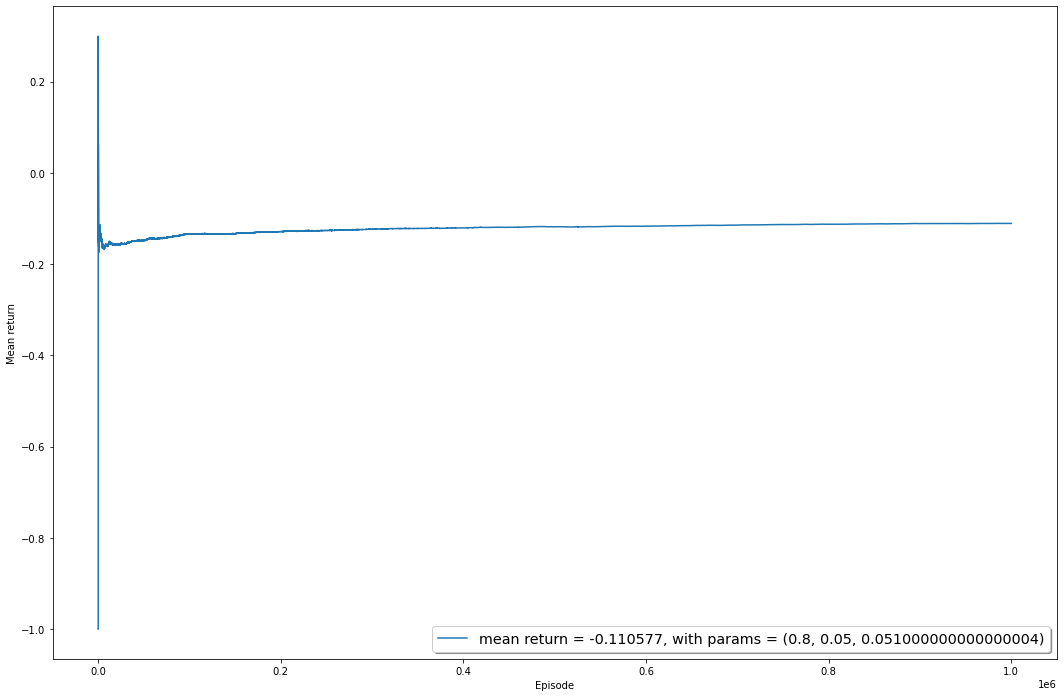

In [17]:
plt.figure(figsize=(18,12))
epsilons = np.arange(.05, .21, .05)
gammas = np.arange(.1, 1.1, .1)
alphas = np.arange(.001, .151, .025)
env_with_counting = bj_counting.BlackjackEnv(counting_method='PN')

best_epsilon, best_gamma, best_alpha = tune_mc_control_hyperparams(env_with_counting, epsilons, gammas, alphas)
_, _, rewards_mc = mc_control(env_with_counting, TOTAL_EPISODES, epsilon=best_epsilon, gamma=best_gamma, alpha=best_alpha)
mean_rewards = [cs / (i+1) for i, cs in enumerate(np.cumsum(rewards_mc))]
plt.plot(mean_rewards, label=f'mean return = {np.mean(rewards_mc)}, with params = {(best_gamma,best_epsilon,best_alpha)}')
plt.legend(loc='lower right', shadow=True, fontsize='x-large')
plt.xlabel('Episode')
plt.ylabel('Mean return')
plt.show()

Тестируем результаты с подходом "Половинки" (Halves)

100%|██████████| 4/4 [04:44<00:00, 71.18s/it]


Best epsilon = 0.05, best gamma = 0.7000000000000001, best_alpha = 0.126


100%|██████████| 1000000/1000000 [02:10<00:00, 7652.94it/s]


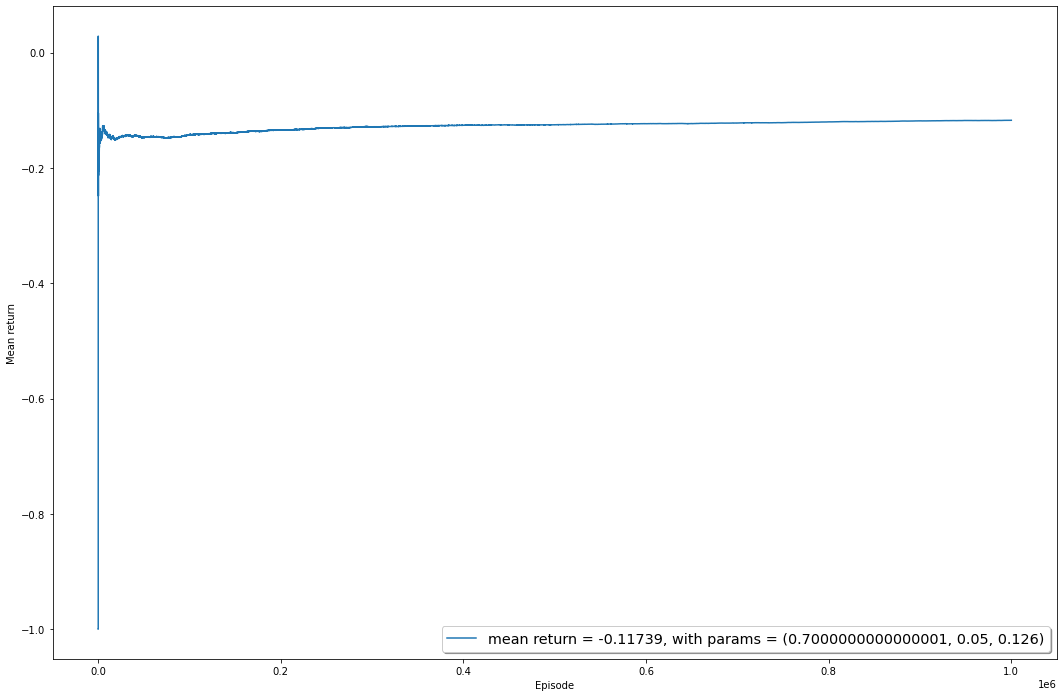

In [18]:
plt.figure(figsize=(18,12))
epsilons = np.arange(.05, .21, .05)
gammas = np.arange(.1, 1.1, .1)
alphas = np.arange(.001, .151, .025)
env_with_counting = bj_counting.BlackjackEnv(counting_method='halves')
best_epsilon, best_gamma, best_alpha = tune_mc_control_hyperparams(env_with_counting, epsilons, gammas, alphas)
_, _, rewards_mc = mc_control(env_with_counting, TOTAL_EPISODES, epsilon=best_epsilon, gamma=best_gamma, alpha=best_alpha)
mean_rewards = [cs / (i+1) for i, cs in enumerate(np.cumsum(rewards_mc))]
plt.plot(mean_rewards, label=f'mean return = {np.mean(rewards_mc)}, with params = {(best_gamma,best_epsilon,best_alpha)}')
plt.legend(loc='lower right', shadow=True, fontsize='x-large')
plt.xlabel('Episode')
plt.ylabel('Mean return')
plt.show()

Итого:
+ Как ни странно, но лучшее качество достигается при отсутсвии подсчета карт и возможности удвоения при использовании MC On-policy Control
+ Результаты дублирования без подсчета карт и с подсчетом - практически идентичны, независимо от стратегии подсчета
+ Возможно стоит попробовать другой адгоритм или более серьезно "потюнить" гиперпараметры алгоритма (на большем кол-ве итераций), однако это очень долго :) 